In [14]:
import os
import sys
import math
import random
import itertools
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import QuantumCircuit, Aer, execute, assemble, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Operator
from qiskit.circuit.library import XGate
from qiskit.visualization import plot_histogram

# from qiskit_textbook.tools import array_to_latex

In [15]:
path = os.getcwd()
print(path)

d:\VANDAN DAIICT\Summer Internship\Codes\My


In [16]:
print('Enter the number of random walkers in a Cubelike graph.')
k = int(input())
print('Enter the dimension of the Cubelike graph.')
n = int(input())
print('Minimum degree allowed: ',n,'\nMaximum degree allowed: ',2**n-1)

while True:
    print('Enter the size of the generating set.')
    d = int(input())
    if d<n or d>2**n-1:
        if d<n:
            print('The size is too small for the graph to be connected')
        elif d>2**n-1:
            print('The size is too high for the graph to be constructed')
        print('Do you want to enter the size of the generating set again?')
        option = input()
        if option == 'y' or option == 'Y':
            continue
        else:
            raise Exception('Integers below n and above 2^n not allowed')
    else:
        break        

Enter the number of random walkers in a Cubelike graph.


Enter the dimension of the Cubelike graph.
Minimum degree allowed:  4 
Maximum degree allowed:  15
Enter the size of the generating set.


In [17]:
N = 2**n ### number of vertices in the graph
m = math.ceil(math.log(d,2)) ### number of qubits required
Vertex_set = [v for v in range(N)]
Gen_set = [2**i for i in range(n)]  ###at least n linearly independent sets required to generate the group
print('Vertex set: ', Vertex_set, '\nInitialized Generating set: ',Gen_set)

Vertex set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Initialized Generating set:  [1, 2, 4, 8]


In [18]:
if n<d:
    if d == 2*n-1:
        print('Do you want to generate Augment cube')
        option = input()
        if option == 'y' or option == 'Y':
            for x in range(1,n):
                vertex = 1
                for y in range(1,x+1):
                    vertex = vertex^(2**y)
                Gen_set += [vertex]
        else:
            print('Do you want to enter the remaining elements in the generating set')
            option = input()
            if option == 'y' or option == 'Y':
                print('Please enter the remaining integers (>0 and <=',N-1,').')
                Gen_set += [int(input()) for count in range(d-n)]
            else:
                Remained_vertex = list(set(Vertex_set) - set(Gen_set)) ###standard basis removed to select from rest
                Remained_vertex.remove(0)
                Add_gen_vertex = random.sample(Remained_vertex, d-n)
                Gen_set += Add_gen_vertex

    else:
        print('Do you want to enter the remaining elements in the generating set')
        option = input()
        if option == 'y' or option == 'Y':
            print('Please enter the remaining integers (>0 and <=',N-1,').')
            Gen_set += [int(input()) for count in range(d-n)]
        else:
            Remained_vertex = list(set(Vertex_set) - set(Gen_set)) ###standard basis removed to select from rest
            Remained_vertex.remove(0)
            Add_gen_vertex = random.sample(Remained_vertex, d-n)
            Gen_set += Add_gen_vertex

print('Generating set: ', [bin(x)[2:].zfill(n) for x in Gen_set])

Generating set:  ['0001', '0010', '0100', '1000']


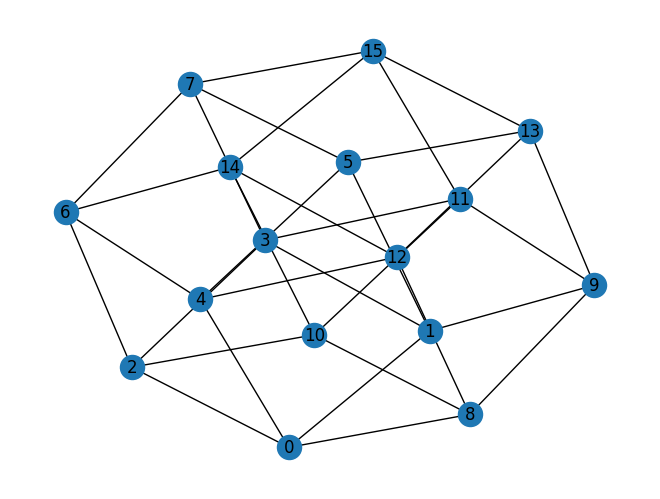

In [19]:
G = nx.Graph()
for edge in itertools.product(range(N),range(N)):
    value = edge[0]^edge[1]
    if value in Gen_set:
        G.add_edge(edge[0], edge[1])
nx.draw(G, with_labels = True)
plt.show()

Do you want to construct matrix for Grover operator (y/n)
Statevector([ 0.5-8.71576399e-33j, -0.5-6.12323400e-17j,
             -0.5-6.12323400e-17j, -0.5-1.22464680e-16j],
            dims=(2, 2))


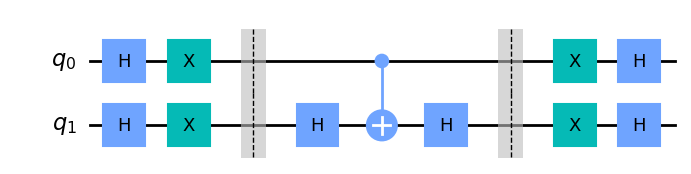

In [20]:
print('Do you want to construct matrix for Grover operator (y/n)')
ans = 'n' #input()
if ans == 'y' or ans == 'Y':
    Grover_op = (2/d)*ones(d)-eye(d)
    
    for increment in range(d, 2**m):
        Grover_op = Grover_op.col_insert(increment, Matrix([0 for i in range(increment)]))
        Grover_op = Grover_op.row_insert(increment, Matrix([[0 for i in range(increment)]+[-1]]))
    Grover = QuantumCircuit(m, name = 'Grover')
    Grover.append(Operator(np.matrix(Grover_op)),range(m))
elif m>1:
    Grover = QuantumCircuit(m, name = 'Grover')
    Grover.h(range(m))
    Grover.x(range(m))
    Grover.barrier()
    Grover.h(m-1)
    Grover.append(XGate().control(m-1),[i for i in range(m)])
    Grover.h(m-1)
    Grover.barrier()
    Grover.x(range(m))
    Grover.h(range(m))
elif m==1:
    Grover = QuantumCircuit(1, name = 'Grover')
    Grover.h(0)
    Grover.x(0)
    Grover.z(0)
    Grover.x(0)
    Grover.h(0)

backend = Aer.get_backend('statevector_simulator')
job = execute(Grover, backend)
result = job.result()
v = result.get_statevector()
print(v)

# Grover = Grover.decompose()
Grover.draw('mpl')

[5, 4] [3, 2, 1, 0] [1, 0]


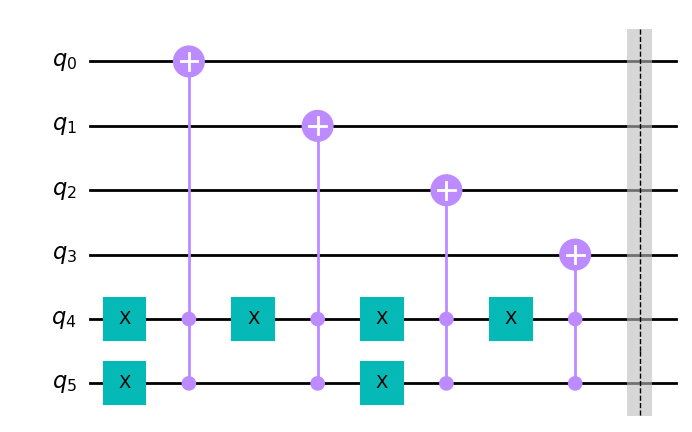

In [21]:
### we will move from 000 towards 111, instead reverse
Shift_op = QuantumCircuit(n+m, name = 'Shift')
control_qubits = [n+m-1-i for i in range(m)]
state_qubits = [n-1-i for i in range(n)]
coin_qubits = [m-1-i for i in range(m)]

print(control_qubits, state_qubits, coin_qubits)

balance_X = [0]*m
for i in range(d): ###Gen_set, labelling done from 0 to d-1 
    edge_label = Gen_set[i]
    target_qubits = [int(x) for x in str(bin(edge_label)[2:].zfill(n))] ###vertex qubits 
    control_X = [int(x) for x in str(bin(i)[2:].zfill(m))]  ###shifts for 1
    #print(i,'\t',edge_label,'\t',control_X,'\t',target_qubits)
    
    for x in coin_qubits:
        Shift_op.x(n+m-1-x)
        balance_X[x] = balance_X[x]^1
        #print(x,':\tbalanced X:',balance_X)
        if control_X[x] == 1:
            break
    for target in state_qubits:
        if target_qubits[target] == 1:
            Shift_op.append(XGate().control(m), control_qubits + [n-1-target])
    
Shift_op.barrier()
for balance in coin_qubits:
    if balance_X[balance] == 1:
        Shift_op.x(n+m-1-balance)

Shift_op.draw('mpl')

Statevector([0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j,
             0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j,
             0. +0.j, 0.5+0.j],
            dims=(2, 2, 2, 2))


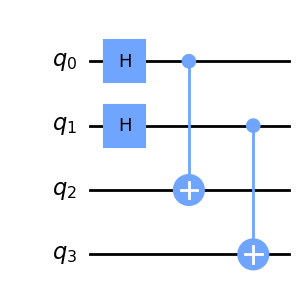

In [22]:
Coin_space = QuantumCircuit(m*k, name = 'Coin')

# initial_vector = [1/math.sqrt(d)]*d + [0]*(2**m-d)
# qc.initialize(initial_vector, range(n,n+m))

Coin_space.h(range(m))

for j in range(m):
    Coin_space.cx(j, range(j+m, k*m, m))

backend = Aer.get_backend('statevector_simulator')
job = execute(Coin_space, backend)
result = job.result()
v = result.get_statevector()
print(v)

Coin_space.draw('mpl')
        

Enter the starting number of step
Enter the ending number of step
no. of steps from:  1  to  2  are :  2

step no.:  1
counts:  {'00010001': 256, '00100010': 279, '01000100': 221, '10001000': 268}
no. of counts:  4


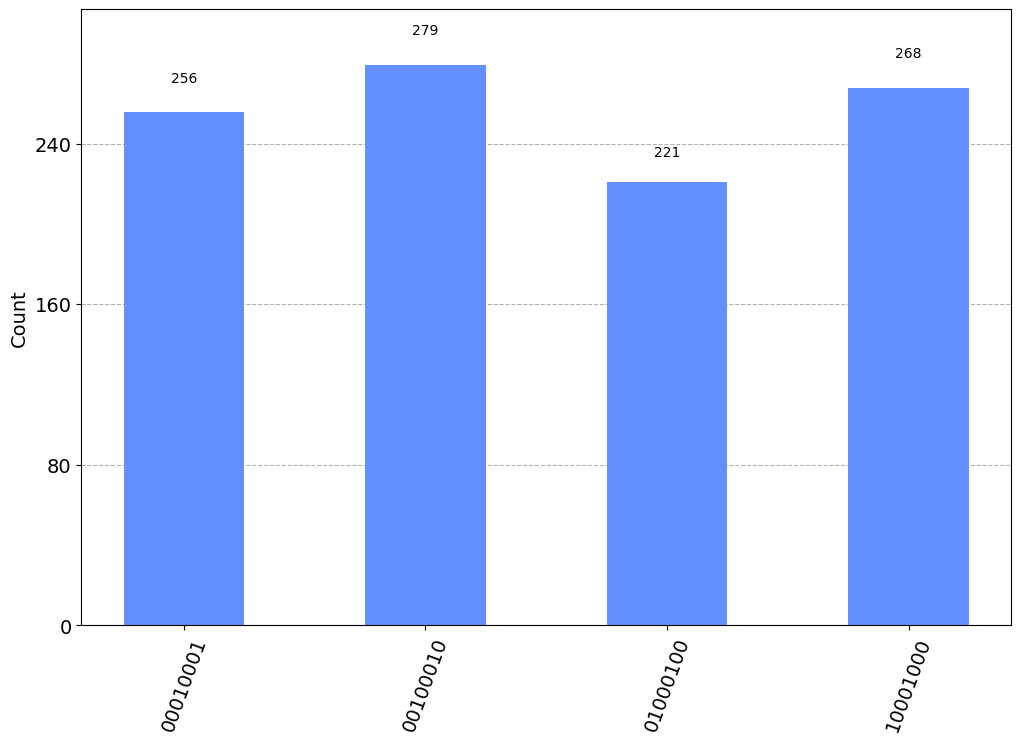


step no.:  2
counts:  {'10100011': 14, '10011100': 19, '00110101': 14, '01101100': 16, '00110000': 30, '11001100': 26, '00110011': 36, '00000110': 38, '11001010': 25, '10101001': 10, '10011010': 14, '00000000': 67, '10101010': 36, '10011001': 41, '01010000': 31, '00000011': 28, '00111010': 14, '01011001': 20, '01100000': 25, '11000000': 33, '00111001': 16, '11000110': 16, '10010000': 32, '00001010': 32, '01100011': 20, '10100000': 23, '00001001': 32, '01100110': 40, '11000101': 14, '10010011': 14, '01010101': 27, '01010011': 19, '01101010': 8, '10100110': 10, '01100101': 24, '00000101': 29, '11001001': 17, '00001100': 33, '01010110': 23, '01011100': 16, '10101100': 8, '10010101': 19, '00110110': 15}
no. of counts:  43


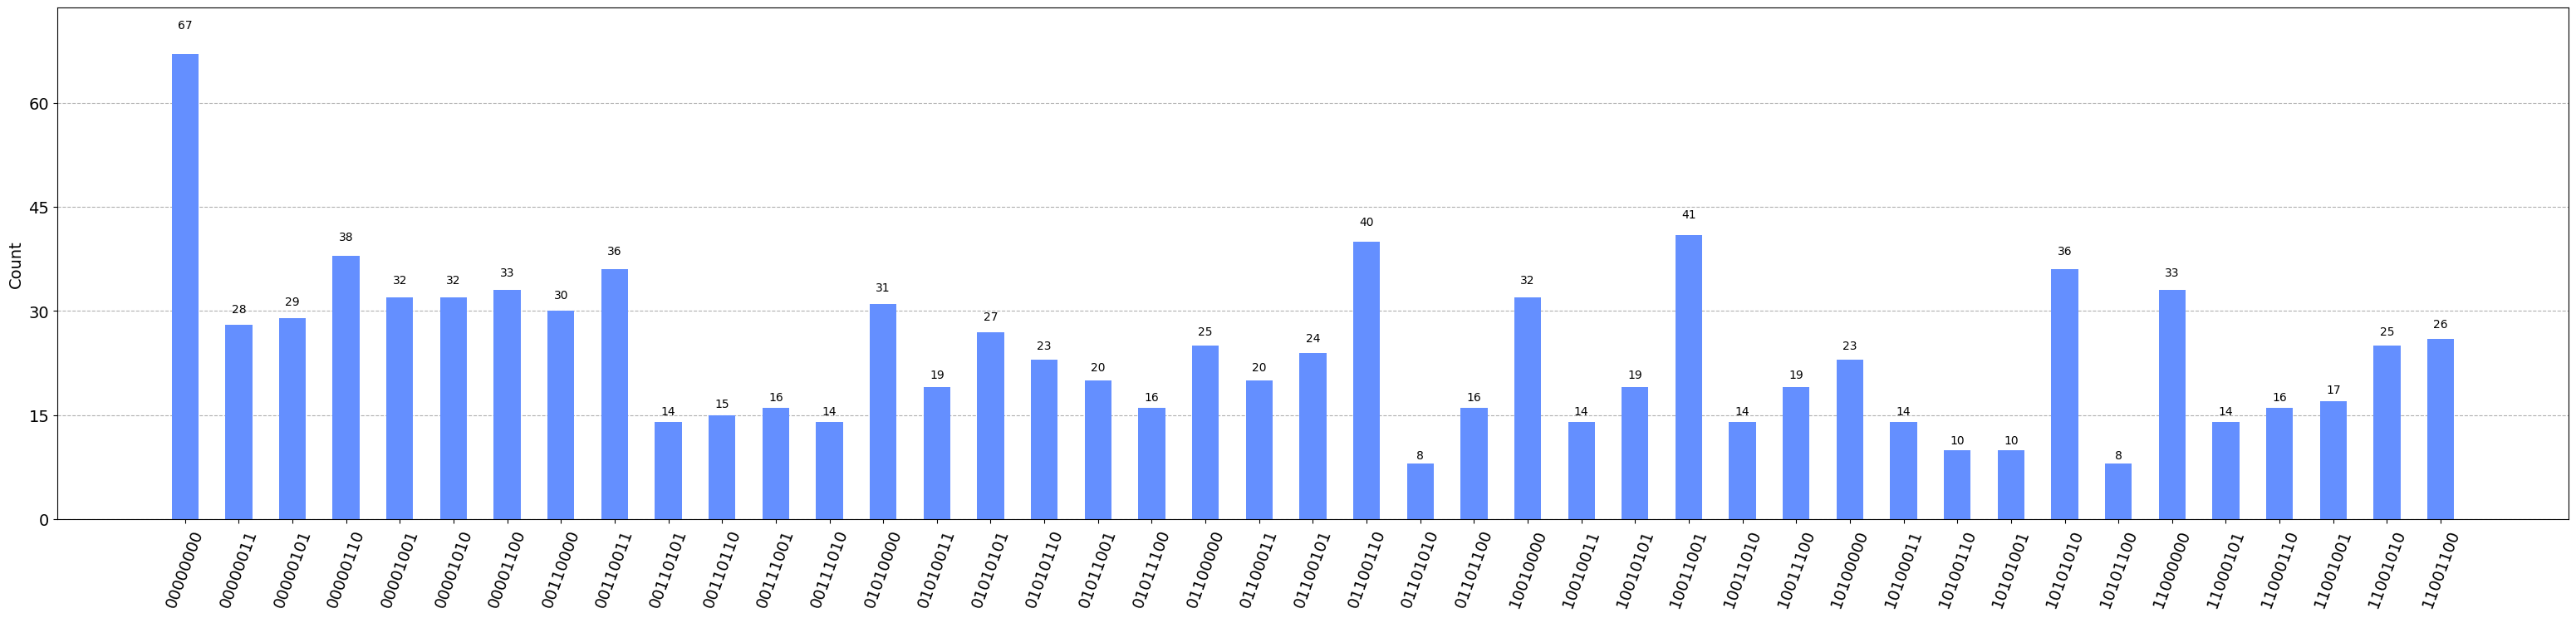

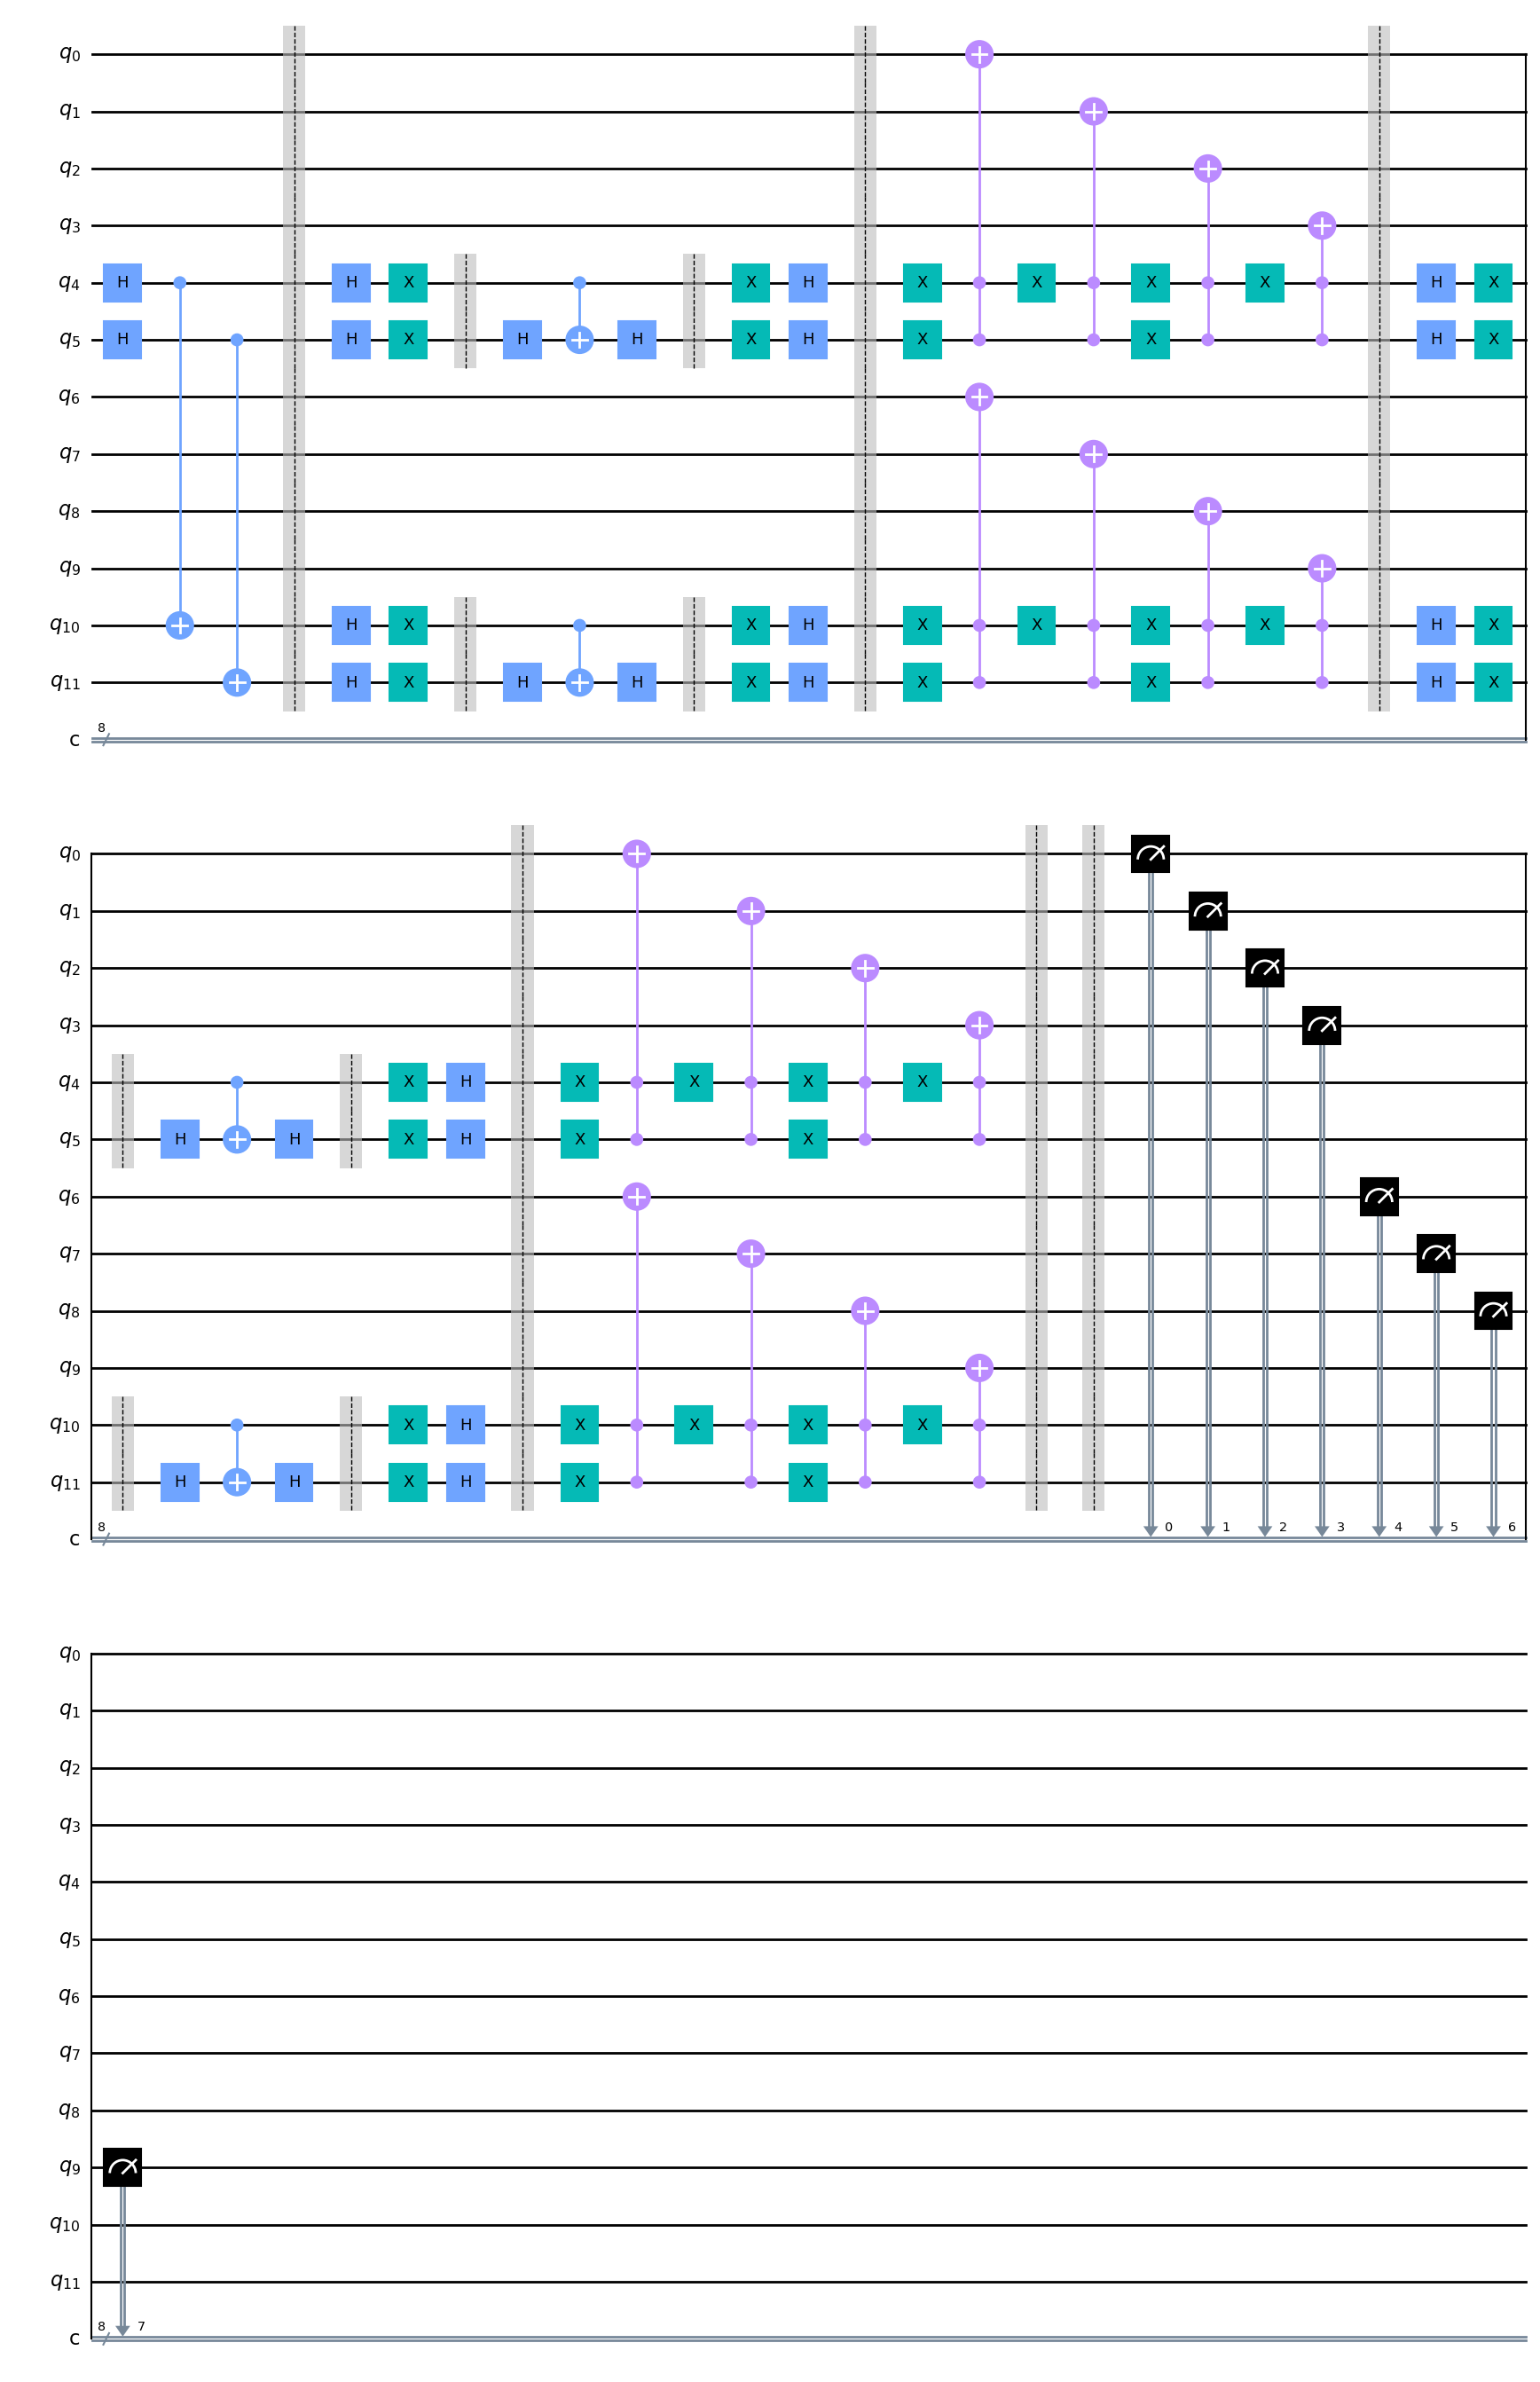

In [24]:
print('Enter the starting number of step')
first_step = int(input())
print('Enter the ending number of step')
last_step = int(input())
print('no. of steps from: ', first_step, ' to ', last_step, ' are : ', last_step-first_step+1)
    
Coin_qubits = [j for i in range(n,k*(n+m),n+m) for j in range(i,i+m)]

list=[]

for steps in range(first_step,last_step+1):
    qc = QuantumCircuit(k*(n+m),k*n)

    qc.append(Coin_space, Coin_qubits)
    qc.barrier()

    for step in range(steps):
        for i in range(k):
            qc.append(Grover, range(i*(n+m)+n,(i+1)*(n+m)))
        qc.barrier()
        for i in range(k):
            qc.append(Shift_op, range(i*(n+m),(i+1)*(n+m)))
    qc.barrier()

    for i in range(k):
        for j in range(n):
            qc.measure(i*(m+n)+j,i*n+j)

    qc = qc.decompose()
    list.append(qc)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend)
    result = job.result()
    counts = result.get_counts()
    print('\nstep no.: ', steps)
    print('counts: ', counts)
    print('no. of counts: ', len(counts))

    plot = plot_histogram(counts, figsize=(int(6*len(counts)**(1/2)),8))
    # plot = plot_histogram(counts, figsize=(int(6*len(counts)**(1/2)),8), sort='value_desc')
    display(plot)

print('The Quantum Circuit for ', last_step, 'number of steps')
list[-1].draw('mpl')